In [1]:
from pyrpl import Pyrpl

In [2]:
#HOSTNAME = "132.72.14.12"
HOSTNAME = "132.72.13.15"
p = Pyrpl(hostname = HOSTNAME, config="rp-f0b1b0.yml")

INFO:pyrpl:All your PyRPL settings will be saved to the config file
    C:\Users\`Owner\pyrpl_user_dir\config\rp-f0b1b0.yml
If you would like to restart PyRPL with these settings, type "pyrpl.exe rp-f0b1b0" in a windows terminal or 
    from pyrpl import Pyrpl
    p = Pyrpl('rp-f0b1b0')
in a python terminal.
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname 132.72.13.15.


In [3]:
# Access the RedPitaya object in charge of communicating with the board
r = p.rp

#check the value of input1
print(r.scope.voltage_in1)

-0.02294921875


Rough time to read one FPGA register:  344.6783224741618 us


Text(0.5, 1.0, 'ADC voltage histogram')

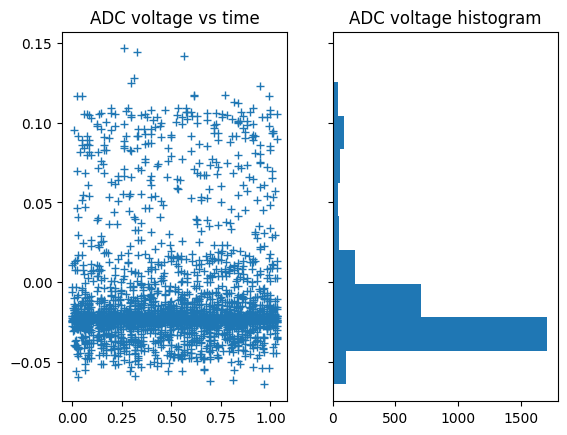

In [4]:
#see how the adc reading fluctuates over time
import time
from matplotlib import pyplot as plt
times, data = [],[]
t0 = time.time()
n = 3000
for i in range(n):
    times.append(time.time()-t0)
    data.append(r.scope.voltage_in1)
print("Rough time to read one FPGA register: ", (time.time()-t0)/n*1e6, "us")
%matplotlib inline
f, axarr = plt.subplots(1,2, sharey=True)
axarr[0].plot(times, data, "+")
axarr[0].set_title("ADC voltage vs time")
axarr[1].hist(data, bins=10, orientation="horizontal")
axarr[1].set_title("ADC voltage histogram")

In [5]:
r.hk #"housekeeping" = LEDs and digital inputs/outputs
r.ams #"analog mixed signals" = auxiliary ADCs and DACs.

r.scope #oscilloscope interface

r.asg0 #"arbitrary signal generator" channel 0
r.asg1 #"arbitrary signal generator" channel 1

r.pid0 #first of three PID modules
r.pid1
r.pid2

r.iq0 #first of three I+Q quadrature demodulation/modulation modules
r.iq1
r.iq2

r.iir #"infinite impulse response" filter module that can realize complex transfer functions

In [6]:
# Let’s set up the ASG to output a sawtooth signal of amplitude 0.8 V (peak-to-peak 1.6 V) at 1 MHz on output 2:
asg = r.asg1
asg.output_direct = 'out2'
asg.setup(waveform='halframp', frequency=20e4, amplitude=0.8, offset=0, trigger_source='immediately')

In [7]:
s = r.scope # shortcut
print("Available decimation factors:", s.decimations)
print("Trigger sources:", s.trigger_sources)
print("Available inputs: ", s.inputs)

Available decimation factors: odict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536])
Trigger sources: odict_keys(['off', 'immediately', 'ch1_positive_edge', 'ch1_negative_edge', 'ch2_positive_edge', 'ch2_negative_edge', 'ext_positive_edge', 'ext_negative_edge', 'asg0', 'asg1', 'dsp'])
Available inputs:  ['in1', 'in2', 'out1', 'out2', 'iq0', 'iq1', 'iq2', 'iq2_2', 'pid0', 'pid1', 'pid2', 'asg0', 'asg1', 'trig', 'iir', 'off', 'networkanalyzer', 'lockbox.inputs.input_from_output', 'lockbox.outputs.output1', 'lockbox.outputs.output2']


Before turning on asg:
Curve ready: False
After turning on asg:
Curve ready: True
Trigger event age [ms]: 29.986624000000003


Text(0, 0.5, 'Voltage')

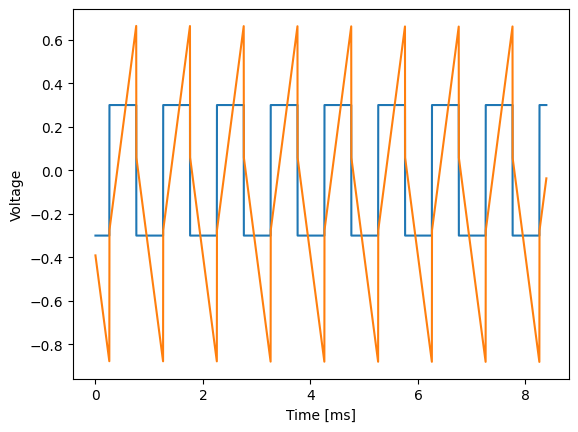

In [15]:
from pyrpl.async_utils import sleep
s = r.scope

# turn off asg so the scope has a chance to measure its "off-state" as well
asg.output_direct = "off"

# setup scope
s.input1 = 'asg1'

# pass asg signal through pid0 with a simple integrator - just for fun (detailed explanations for pid will follow)
r.pid0.input = 'asg1'
r.pid0.ival = 0 # reset the integrator to zero
r.pid0.i = 1000 # unity gain frequency of 1000 hz
r.pid0.p = 1.0 # proportional gain of 1.0
r.pid0.inputfilter = [0,0,0,0] # leave input filter disabled for now

# show pid output on channel2
s.input2 = 'pid0'

# trig at zero volt crossing
s.threshold = 0

# positive/negative slope is detected by waiting for input to
# sweep through hysteresis around the trigger threshold in
# the right direction
s.hysteresis = 0.01

# trigger on the input signal positive slope
s.trigger_source = 'immediately'

# take data symetrically around the trigger event
s.trigger_delay = 0

# set decimation factor to 64 -> full scope trace is 8ns * 2^14 * decimation = 8.3 ms long
s.decimation = 64

# launch a single (asynchronous) curve acquisition, the asynchronous
# acquisition means that the function returns immediately, eventhough the
# data-acquisition is still going on.
res = s.curve_async()

print("Before turning on asg:")
print("Curve ready:", s.curve_ready()) # trigger should still be armed

# turn on asg and leave enough time for the scope to record the data
asg.setup(amplitude=0.3,frequency = 1e3, waveform='square', trigger_source='immediately')
sleep(0.010)

# check that the trigger has been disarmed
print("After turning on asg:")
print("Curve ready:", s.curve_ready())
print("Trigger event age [ms]:",8e-9*((
s.current_timestamp&0xFFFFFFFFFFFFFFFF) - s.trigger_timestamp)*1000)

# The function curve_async returns a *future* (or promise) of the curve. To
# access the actual curve, use result()
ch1, ch2 = res.result()

# plot the data
%matplotlib inline
plt.plot(s.times*1e3, ch1, s.times*1e3, ch2)
plt.xlabel("Time [ms]")
plt.ylabel("Voltage")

In [9]:
# useful functions for scope diagnostics
print("Curve ready:", s.curve_ready())
print("Trigger source:",s.trigger_source)
print("Trigger threshold [V]:",s.threshold_ch1)
print("Averaging:",s.average)
print("Trigger delay [s]:",s.trigger_delay)
print("Trace duration [s]: ",s.duration)
print("Trigger hysteresis [V]", s.hysteresis_ch1)
print("Current scope time [cycles]:",hex(s.current_timestamp))
print("Trigger time [cycles]:",hex(s.trigger_timestamp))
print("Current voltage on channel 1 [V]:", r.scope.voltage_in1)
print("First point in data buffer 1 [V]:", s.ch1_firstpoint)

Curve ready: True
Trigger source: immediately
Trigger threshold [V]: 0.0
Averaging: False
Trigger delay [s]: 0.0
Trace duration [s]:  0.008388608
Trigger hysteresis [V] 0.010009765625
Current scope time [cycles]: 0x59bb72cd
Trigger time [cycles]: 0x56f7b021
Current voltage on channel 1 [V]: -0.300048828125
First point in data buffer 1 [V]: 0.7999267578125


AttributeError: 'Scope' object has no attribute 'ch1'

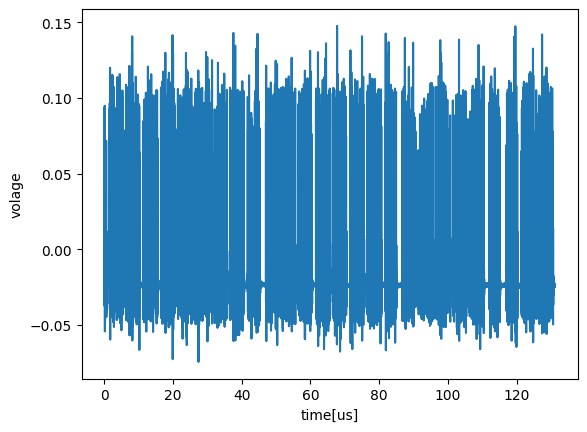

In [29]:
def callback(res):
    data = res.result()
    plt.plot((s.times*1e6)[:], data[0][:])
    plt.xlabel("time[us]")
    plt.ylabel("volage")  
      

#my own attempt at reading data from RP
s.input1 = "in1"
s.trigger_source = "immediately"
# print(s.duration_options)
# s.duration = 12e-6 # [s]
s.decimation = 1  

res = s.curve_async()
res.add_done_callback(callback)
# print(type(res))
sleep(0.01)

# print("ready: ", s.curve_ready())
# print(s.curve_ready())

# while not s.curve_ready():

# data = res.result()
# plt.plot((s.times*1e6)[:], data[0][:])
# plt.xlabel("time[us]")
# plt.ylabel("volage")

OrderedDict([('led', 0),
             ('expansion_P0', False),
             ('expansion_P1', False),
             ('expansion_P2', True),
             ('expansion_P3', True),
             ('expansion_P4', True),
             ('expansion_P5', True),
             ('expansion_P6', True),
             ('expansion_P7', True),
             ('expansion_N0', False),
             ('expansion_N1', False),
             ('expansion_N2', True),
             ('expansion_N3', True),
             ('expansion_N4', True),
             ('expansion_N5', True),
             ('expansion_N6', True),
             ('expansion_N7', True)])

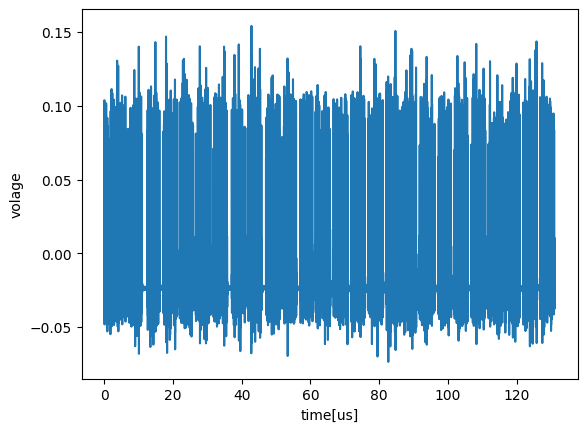

In [11]:
#understanding how to control the digital outputs
# p1 is the trigger for pulse blaster
hk = r.hk

hk.expansion_P1 = 0
hk.get_setup_attributes()


In [12]:
for i in range(111):
    if hk.expansion_P1 == 0:
        hk.expansion_P1 = 1        
    else:
        hk.expansion_P1 = 0

    print(hk.expansion_P1)



True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
